In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), "../src"))
from utils import *

In [2]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchsummary import summary

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Creating a simple dataset using the linear regression formula

We'll use a linear regression to make a straight line with known parameters and see if the neural network can learn these parameters

In [3]:
weight, bias = 0.7, 0.3
start, end, step = 0, 1, 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) #Needed for modelling
y = weight * X  + bias
X.shape, y.shape

(torch.Size([50, 1]), torch.Size([50, 1]))

## 2. Train-test split

In [4]:
from sklearn.model_selection import train_test_split

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


(torch.Size([40, 1]),
 torch.Size([10, 1]),
 torch.Size([40, 1]),
 torch.Size([10, 1]))

## 3. Visualize data

In [6]:
def plot_predictions(train_data = X_train,
                     train_labels = y_train,
                     test_data = X_test,
                     test_labels = y_test,
                     predictions = None):
    """Plots training data, test data and compares predictions

    Args:
        train_data (_type_, optional): _description_. Defaults to X_train.
        train_labels (_type_, optional): _description_. Defaults to y_train.
        test_data (_type_, optional): _description_. Defaults to X_test.
        test_labels (_type_, optional): _description_. Defaults to y_test.
        predictions (_type_, optional): _description_. Defaults to None.
    """
    
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c="b",s=4,
                label = "Training data")
    plt.scatter(test_data, test_labels, c="r", s=4, label="Testing data")
    plt.ylabel('y')
    plt.xlabel('X')
    if predictions is not None:
        plt.scatter(test_data, predictions, c = "k", s=4, label="Model predictions")
    plt.legend()

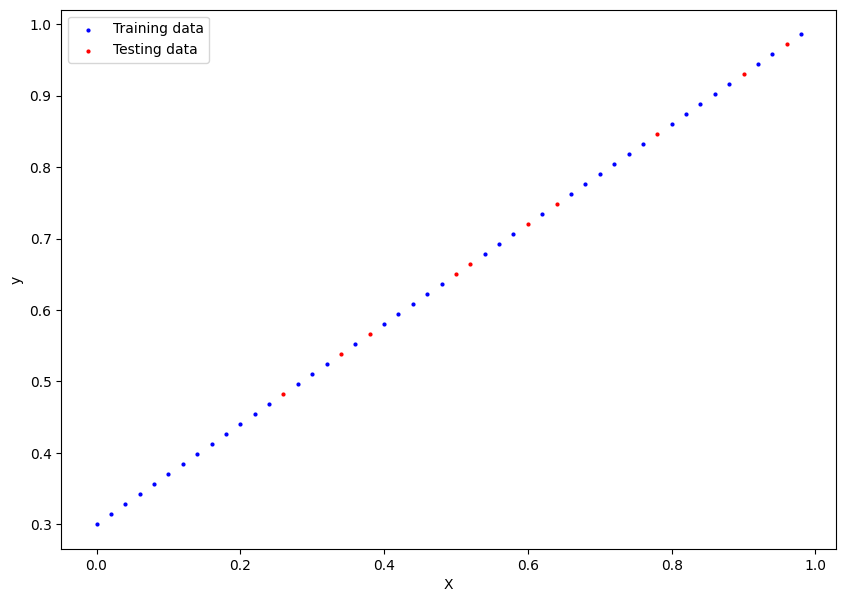

In [6]:
plot_predictions()

## 3. Creating our first PyTorch Model for Linear Regression
The weights and bias are randomly initialized and updated with each epoch.

In [7]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.rand(1,
                                               requires_grad=True,
                                               dtype=torch.float))
        self.bias = nn.Parameter(torch.rand(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # Must always overwrite the nn.Module's forward function
        return self.weights * X + self.bias

In [8]:
SEED = 42
torch.manual_seed(SEED)
device = get_device()
model = LinearRegressionModel()
device, model

('mps', LinearRegressionModel())

In [9]:
list(model.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

The model's state_dict contains the name of the parameter and the value

In [10]:
model.state_dict()

OrderedDict([('weights', tensor([0.8823])), ('bias', tensor([0.9150]))])

## 4. Making predictions with our randomly initialized model using inference mode

In [11]:
model(X_test)

tensor([[1.1444],
        [1.6032],
        [1.4444],
        [1.7090],
        [1.2150],
        [1.7620],
        [1.3738],
        [1.3561],
        [1.4797],
        [1.2503]], grad_fn=<AddBackward0>)

The gradient is still tracked here.

Can overcome this either by using
* `torch.no_grad` or
* `torch.inference_mode`

`torch.inference_mode` is preferred in this context due to better performance as it disables view tracking and version counter bumps.

`torch.no_grad` is used if you want to set the attribute on tensors back to `requires_grad`.

In [12]:
with torch.inference_mode(): #This turns off the gradient update
    y_preds = model(X_test)

y_preds

tensor([[1.1444],
        [1.6032],
        [1.4444],
        [1.7090],
        [1.2150],
        [1.7620],
        [1.3738],
        [1.3561],
        [1.4797],
        [1.2503]])

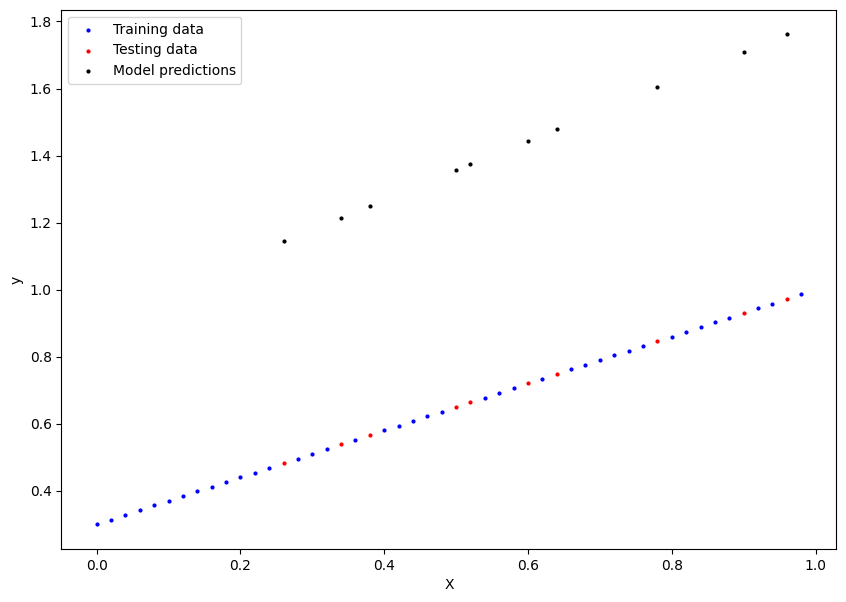

In [13]:
plot_predictions(predictions = y_preds)

## 5. Training the model to see if we can get the ideal parameters for linear regression
Here are some things we will need for model training:
* The loss function we're trying to optimize is MAE, which is `torch.nn.L1Loss`.
* We need an optimizer
* Training loop (specific to PyTorch)
* Testing loop (specific to PyTorch)

In [14]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.01)

### Building training and testing loops in PyTorch
We need to: 
* Loop through the data
* Forward pass (involves data moving through our model's `forward` function)
* Compute loss (compare forward pass predictions to ground truth labels)
* Optimizer zero grad
* Backpropogation - move backwards to calculate the gradients of each of the parameters of our model with respect to the loss.
* Optimizer step - use the optimizer to reduce the value of the loss function by gradient descent 

In [17]:
epochs = 100 #An epoch refers to one loop (pass) through the data
epoch_set, train_losses, test_losses = [], [], []
torch.manual_seed(SEED)

for epoch in range(epochs):
    # Set the model to training mode (all parameters -> requires grad)
    model.train()
    
    # Forward pass
    y_pred = model(X_train)
    
    # Compute loss
    loss = loss_fn(y_pred, y_train)
    
    # Optimizer zero grad
    optimizer.zero_grad()
    
    # Back propogation
    loss.backward()
    
    # Perform gradient descent - the optimizer's changes accumulate
    # through the loop. So we have to zero them above to start fresh
    # for each pass through the loop
    optimizer.step()
    
    print(model.state_dict())
    
    # Turn the model to evaluation mode
    model.eval()
    
    # Turn off requires_grad flag and makes PyTorch run faster
    # torch.no_grad is used for older PyTorch versions
    with torch.inference_mode():
        
        # Get prediction on test set (forward pass)
        test_pred = model(X_test)
        
        # Compute loss on test set
        test_loss = loss_fn(test_pred, y_test)
        
        # Print out what's happening
        if epoch %10 == 0:
            epoch_set.append(epoch)
            train_losses.append(loss.detach().numpy())
            test_losses.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")
    

OrderedDict([('weights', tensor([0.8683])), ('bias', tensor([0.8850]))])
Epoch: 0 | MAE Train Loss: 0.6755164861679077 | MAE Test Loss: 0.683966875076294
OrderedDict([('weights', tensor([0.8636])), ('bias', tensor([0.8750]))])
OrderedDict([('weights', tensor([0.8590])), ('bias', tensor([0.8650]))])
OrderedDict([('weights', tensor([0.8543])), ('bias', tensor([0.8550]))])
OrderedDict([('weights', tensor([0.8497])), ('bias', tensor([0.8450]))])
OrderedDict([('weights', tensor([0.8450])), ('bias', tensor([0.8350]))])
OrderedDict([('weights', tensor([0.8404])), ('bias', tensor([0.8250]))])
OrderedDict([('weights', tensor([0.8357])), ('bias', tensor([0.8150]))])
OrderedDict([('weights', tensor([0.8311])), ('bias', tensor([0.8050]))])
OrderedDict([('weights', tensor([0.8264])), ('bias', tensor([0.7950]))])
OrderedDict([('weights', tensor([0.8218])), ('bias', tensor([0.7850]))])
Epoch: 10 | MAE Train Loss: 0.55384761095047 | MAE Test Loss: 0.5565956234931946
OrderedDict([('weights', tensor([0.

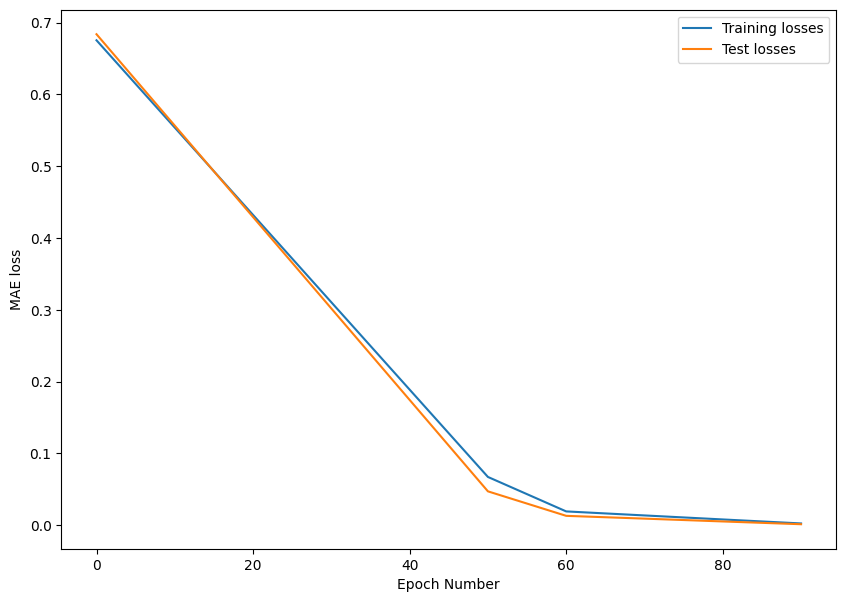

In [24]:
plt.figure(figsize=(10,7))
plt.plot(epoch_set, train_losses, label = 'Training losses')
plt.plot(epoch_set, test_losses, label = 'Test losses')
plt.ylabel('MAE loss')
plt.xlabel('Epoch Number')
plt.legend()
plt.show()

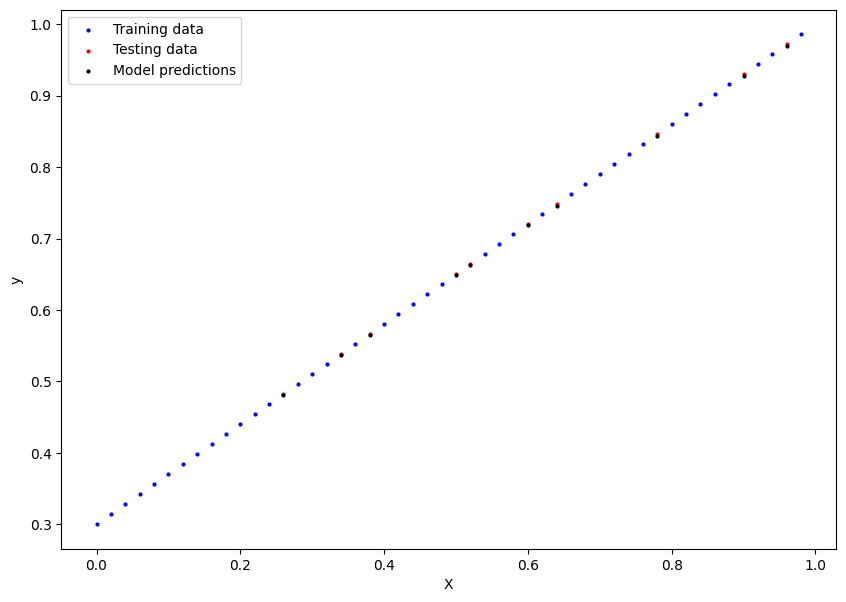

In [20]:
model.eval()
with torch.inference_mode():
    y_preds = model(X_test)
plot_predictions(predictions = y_preds)

In [21]:
model.state_dict()

OrderedDict([('weights', tensor([0.6987])), ('bias', tensor([0.2990]))])

That's really very close to the original parameters we setup!

## Saving models in PyTorch
Here are the main steps <br>
1. `torch.save()` saves a Torch object as a Python `pickle` object
2. `torch.load()` loads a saved Torch object
3. `torch.nn.Module.load_state_dict()` loads a model's saved state dictionary

> Note that all Torch models are saved in a .pth extension

In [26]:
from pathlib import Path

# Create models directory
MODEL_PATH = Path("Models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = '01_pytorch_workflow_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('Models/01_pytorch_workflow_model.pth')

In [27]:
# Save the model's state dict (recommended)
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print("Model saved to:  ", MODEL_SAVE_PATH)

Model saved to:   Models/01_pytorch_workflow_model.pth


In [30]:
import subprocess
cp = subprocess.Popen(['ls','-l','Models'])
cp

<Popen: returncode: None args: ['ls', '-l', 'Models']>

total 8
-rw-r--r--  1 tituslim  staff  1199 Apr 11 21:12 01_pytorch_workflow_model.pth


Load model - we have to instantiate a new instance of our model class

In [35]:
model_loaded = LinearRegressionModel()
model_loaded.load_state_dict(torch.load(MODEL_SAVE_PATH, 
                                        map_location = 'cpu'))
model_loaded.state_dict()

OrderedDict([('weights', tensor([0.6987])), ('bias', tensor([0.2990]))])

In [39]:
model_loaded.eval()
with torch.inference_mode():
    preds = model_loaded(X_test)
preds == y_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Putting everything together
Let's redo everything again

In [3]:
weight, bias = 0.7, 0.3
start, end, step = 0, 1, 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 0)

In [78]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features = 1, #takes in one value of X
                                      out_features = 1 #returns one value of y
                                      )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)
    
torch.manual_seed(42)
model = LinearModel()
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [79]:
device = get_device()
model.to(device)
next(model.parameters()).device

device(type='mps', index=0)

In [80]:
torch.manual_seed(42)

epochs = 200
optimizer = torch.optim.SGD(
    params = model.parameters(),
    lr = 0.01)
loss_fn = nn.L1Loss()
epochs_set, train_losses, test_losses = [], [], []

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model.train()
    train_preds = model(X_train)
    train_loss = loss_fn(train_preds, y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        test_preds = model(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}, Train MAE loss: {train_loss}, Test MAE loss: {test_loss}")
            epochs_set.append(epoch)
            train_losses.append(train_loss.to('cpu').detach().numpy())
            test_losses.append(test_loss.to('cpu').detach().numpy())

Epoch: 0, Train MAE loss: 0.562632143497467, Test MAE loss: 0.5454668402671814
Epoch: 10, Train MAE loss: 0.43707916140556335, Test MAE loss: 0.4238315224647522
Epoch: 20, Train MAE loss: 0.31152617931365967, Test MAE loss: 0.3021961450576782
Epoch: 30, Train MAE loss: 0.18597319722175598, Test MAE loss: 0.18056081235408783
Epoch: 40, Train MAE loss: 0.06077257916331291, Test MAE loss: 0.06034062057733536
Epoch: 50, Train MAE loss: 0.0376102477312088, Test MAE loss: 0.03566418215632439
Epoch: 60, Train MAE loss: 0.03213375434279442, Test MAE loss: 0.02945500984787941
Epoch: 70, Train MAE loss: 0.02701694145798683, Test MAE loss: 0.024621261283755302
Epoch: 80, Train MAE loss: 0.021896345540881157, Test MAE loss: 0.01998407021164894
Epoch: 90, Train MAE loss: 0.016782144084572792, Test MAE loss: 0.015150320716202259
Epoch: 100, Train MAE loss: 0.011667945422232151, Test MAE loss: 0.010316580533981323
Epoch: 110, Train MAE loss: 0.006544734816998243, Test MAE loss: 0.005679377820342779
E

In [81]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7040]], device='mps:0')),
             ('linear_layer.bias', tensor([0.3075], device='mps:0'))])

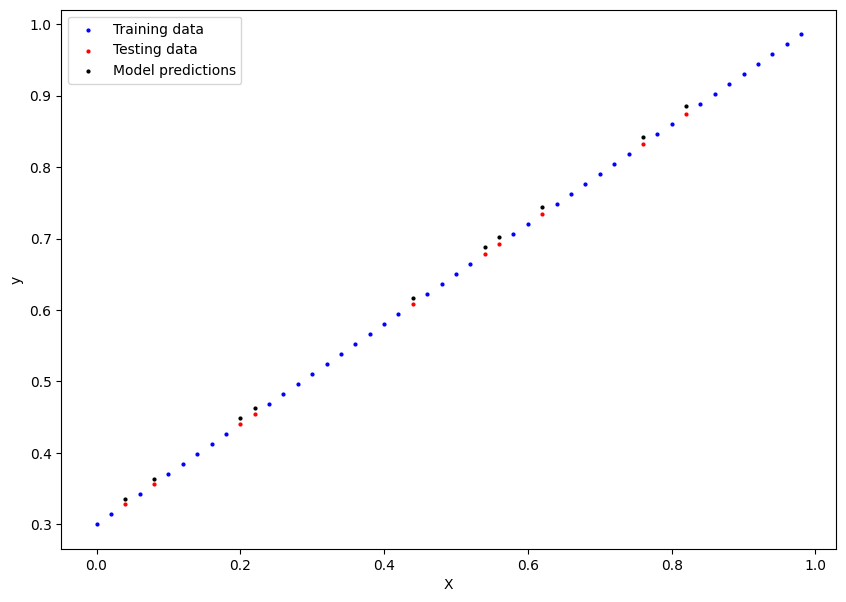

In [82]:
model.eval()
with torch.inference_mode():
    preds = model(X_test).to('cpu')
    plot_predictions(X_train.to('cpu'), 
                     y_train.to('cpu'), 
                     X_test.to('cpu'), 
                     y_test.to('cpu'), preds)

In [83]:
MODEL_NAME = '01_pytorch_workflow_model_200Epochs.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

MODEL_SAVE_PATH

PosixPath('Models/01_pytorch_workflow_model_200Epochs.pth')

In [84]:
torch.save(model.state_dict(), MODEL_SAVE_PATH)

In [98]:
loaded_model = LinearModel()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7040]])),
             ('linear_layer.bias', tensor([0.3075]))])

In [99]:
loaded_model.to(device)
next(loaded_model.parameters()).device

device(type='mps', index=0)

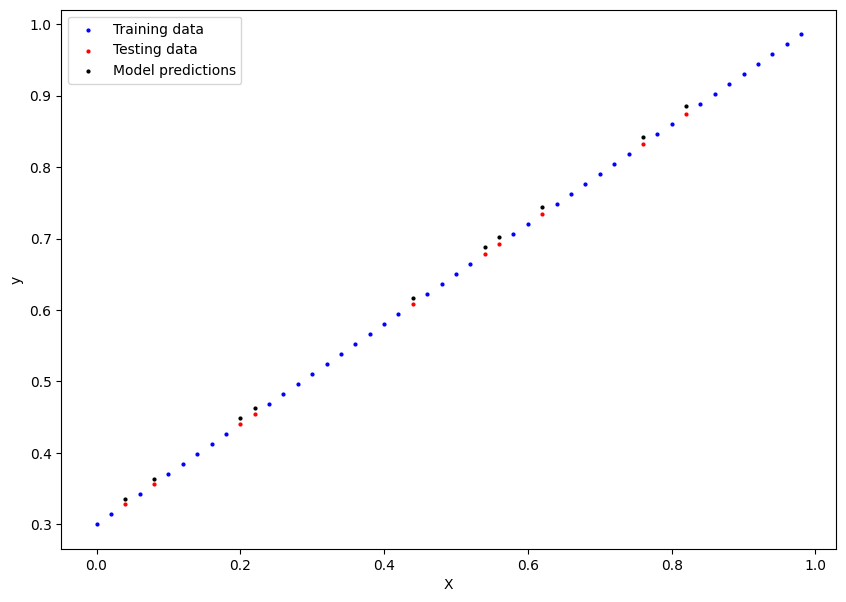

In [104]:
loaded_model.eval()
with torch.inference_mode():
    test_preds = loaded_model(X_test).to('cpu')
    X_train = X_train.to('cpu')
    X_test = X_test.to('cpu')
    y_train = y_train.to('cpu')
    y_test = y_test.to('cpu')
    plot_predictions(X_train, y_train, X_test, y_test, test_preds)

In [105]:
test_preds == preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

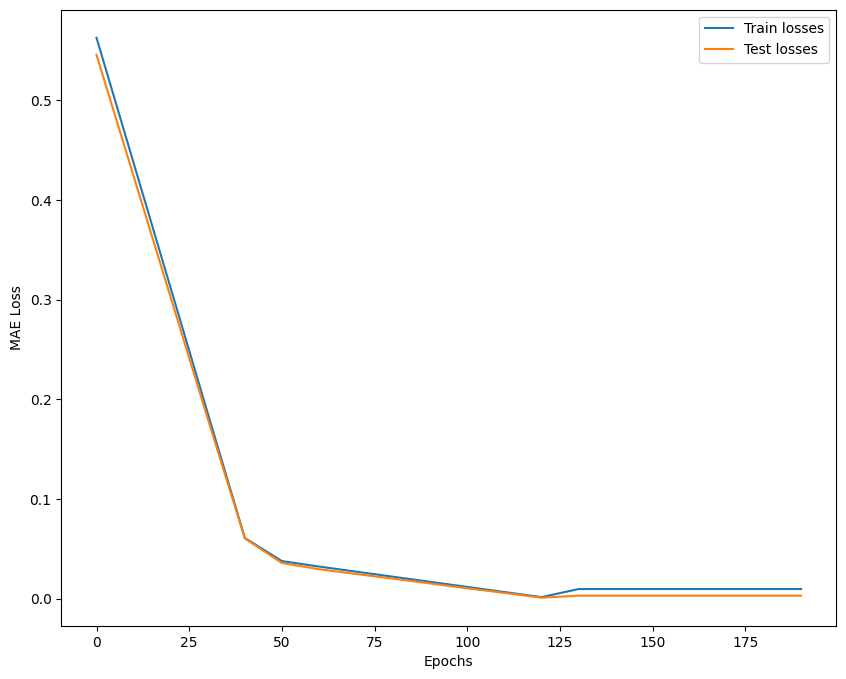

In [106]:
plt.figure(figsize = (10,8))
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.plot(epochs_set, train_losses, label = "Train losses")
plt.plot(epochs_set, test_losses,label = "Test losses")
plt.legend()

## Exercises and Extra Curriculum

In [115]:
weights, bias = 0.3, 0.9
start, end, step = 1, 101, 1
X = torch.arange(start, end, step,
                 dtype = torch.float)
y = weights * X + bias
X[:5], y[:5]

(tensor([1., 2., 3., 4., 5.]),
 tensor([1.2000, 1.5000, 1.8000, 2.1000, 2.4000]))

In [12]:
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,
                                                    random_state = SEED)

len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

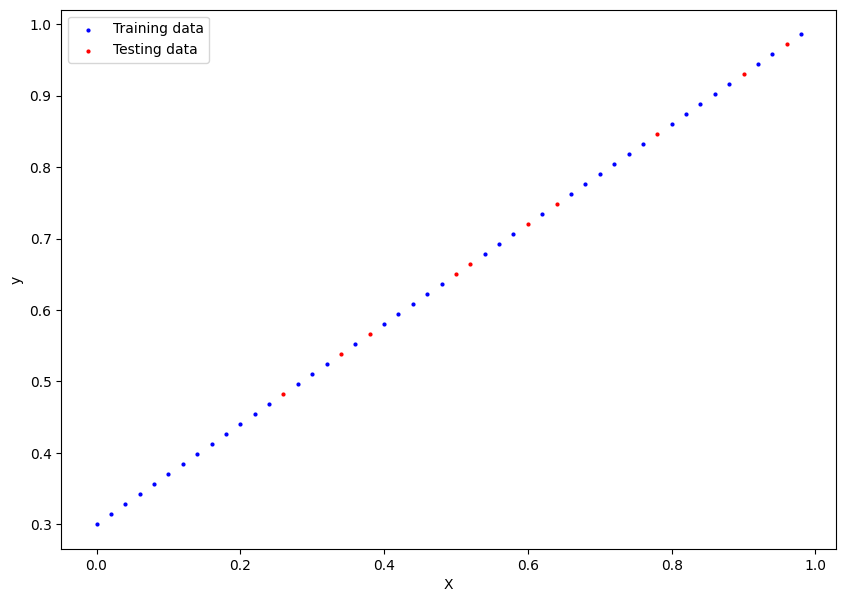

In [13]:
plot_predictions(X_train, y_train, X_test,y_test)

In [18]:
class LinearForecast(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features = 1,
                                      out_features = 1)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

model = LinearForecast()
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

In [19]:
device = get_device()
model = model.to(device)
next(model.parameters()).device

device(type='mps', index=0)

In [20]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [21]:
torch.manual_seed(SEED)
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.01)
epochs = 200

epoch_set, train_losses, test_losses = [], [], []
for epoch in range(epochs):
    model.train()
    train_preds = model(X_train)
    train_loss = loss_fn(train_preds, y_train)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.inference_mode():
        test_preds = model(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Train MAE Loss: {train_loss} | Test MAE Loss: {test_loss}")
            epoch_set.append(epoch)
            train_losses.append(train_loss.to('cpu').detach().numpy())
            test_losses.append(test_loss.to('cpu').detach().numpy())

Epoch: 0 | Train MAE Loss: 0.5600506067276001 | Test MAE Loss: 0.5552194714546204
Epoch: 10 | Train MAE Loss: 0.4383816421031952 | Test MAE Loss: 0.4278481602668762
Epoch: 20 | Train MAE Loss: 0.31671270728111267 | Test MAE Loss: 0.3004767596721649
Epoch: 30 | Train MAE Loss: 0.19504375755786896 | Test MAE Loss: 0.17310546338558197
Epoch: 40 | Train MAE Loss: 0.07337480783462524 | Test MAE Loss: 0.04598527029156685
Epoch: 50 | Train MAE Loss: 0.0360596664249897 | Test MAE Loss: 0.024147970601916313
Epoch: 60 | Train MAE Loss: 0.029995162039995193 | Test MAE Loss: 0.020626747980713844
Epoch: 70 | Train MAE Loss: 0.024409988895058632 | Test MAE Loss: 0.01669568382203579
Epoch: 80 | Train MAE Loss: 0.018832748755812645 | Test MAE Loss: 0.012815380468964577
Epoch: 90 | Train MAE Loss: 0.013247576542198658 | Test MAE Loss: 0.008884328417479992
Epoch: 100 | Train MAE Loss: 0.007668554782867432 | Test MAE Loss: 0.005004018545150757
Epoch: 110 | Train MAE Loss: 0.0020851546432822943 | Test MAE

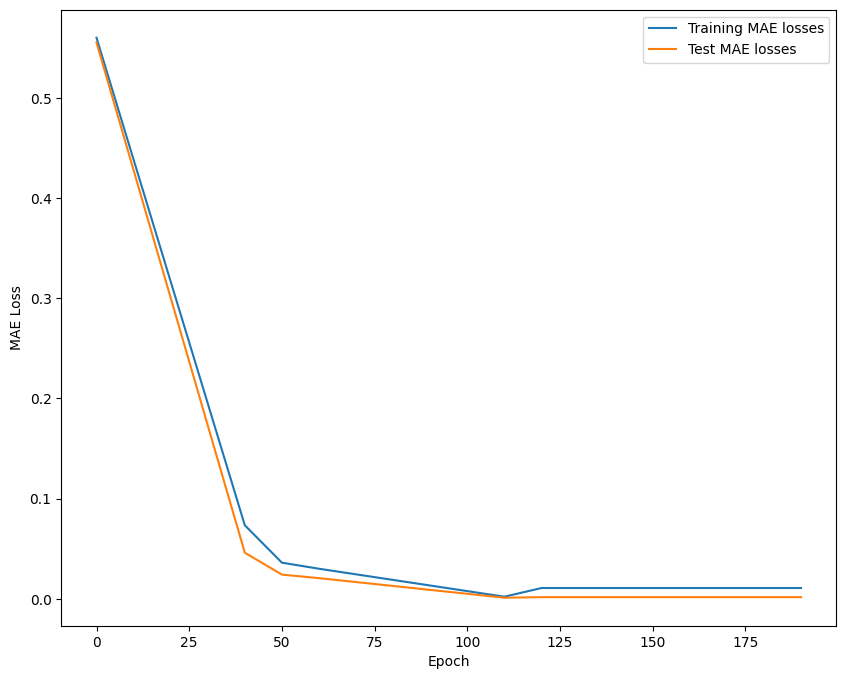

In [27]:
plt.figure(figsize = (10,8))
plt.plot(epoch_set, train_losses, label = "Training MAE losses")
plt.plot(epoch_set, test_losses, label = "Test MAE losses")
plt.legend()
plt.ylabel("MAE Loss")
plt.xlabel("Epoch")
plt.show()

In [23]:
from pathlib import Path
MODEL_PATH = Path("Models")
MODEL_NAME = "01_pytorch_workflow_exercise.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
MODEL_SAVE_PATH

PosixPath('Models/01_pytorch_workflow_exercise.pth')

In [24]:
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to Models/01_pytorch_workflow_exercise.pth


In [31]:
loaded_model = LinearForecast()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)
next(loaded_model.parameters()).device

device(type='mps', index=0)

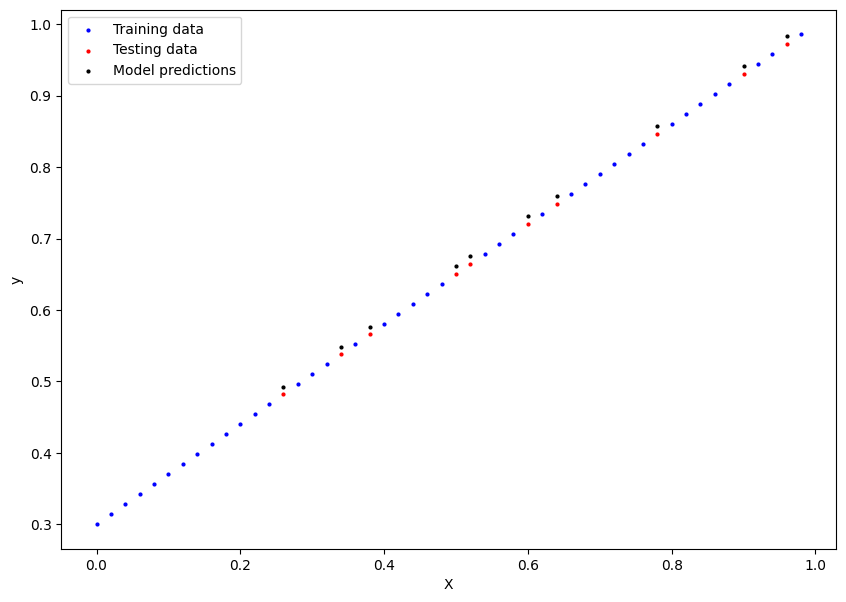

In [34]:
loaded_model.eval()
with torch.inference_mode():
    test_preds = loaded_model(X_test.to(device)).to('cpu')
    X_train = X_train.to('cpu')
    X_test = X_test.to('cpu')
    y_train = y_train.to('cpu')
    y_test = y_test.to('cpu')
    plot_predictions(X_train, y_train, X_test, y_test, test_preds)